# CTA Frequent Network: Ridership Impact Analysis

## Has ridership increased on CTA Frequent Network routes since the program launched?

The **CTA Frequent Network** is a set of 20 bus routes guaranteed to run every **10 minutes or better** during daytime hours (6 AM -- 9 PM weekdays, 9 AM -- 9 PM weekends). The program rolled out in four phases across 2025:

| Phase | Launch Date | Routes |
|-------|------------|--------|
| Phase 1 | March 23, 2025 | J14, 34, 47, 54, 60, 63, 79, 95 |
| Phase 2 | Summer 2025 | 4, 49, 53, 66 |
| Phase 3 | Fall 2025 | 20, 55, 77, 82 |
| Phase 4 | December 21, 2025 | 9, 12, 72, 81 |

In this notebook we:
1. Fetch daily ridership data from the Chicago Data Portal (SODA API)
2. Compute year-over-year ridership changes for each Frequent Network route
3. Visualize monthly ridership trends with launch-date annotations
4. Compare treated (Frequent Network) routes against a matched control group
5. Estimate the causal impact via a difference-in-differences framework

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, timedelta

from bus_check.config import (
    ALL_FREQUENT_ROUTES,
    FREQUENT_NETWORK_PHASES,
    get_phase_for_route,
    get_launch_date,
    SODA_RIDERSHIP_ENDPOINT,
)
from bus_check.data.ridership import fetch_all_routes, fetch_ridership
from bus_check.analysis.ridership_analysis import (
    compute_yoy_change,
    select_control_routes,
    prepare_did_data,
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_rows", 30)

# Phase color palette for consistent visualization
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}
print("Setup complete.")

Setup complete.


## Fetching Ridership Data

We pull daily ridership data from the **Chicago Data Portal** SODA API (`jyb9-n7fm` dataset). This covers all CTA bus routes with columns for route, date, day type (W=weekday, A=Saturday, U=Sunday/holiday), and total rides.

We fetch data from January 2023 through today to have a full year of pre-treatment baseline for all four phases, plus post-treatment observations.

In [2]:
# Fetch all routes from 2023-01-01 through today
today_str = date.today().isoformat()
print(f"Fetching ridership data: 2023-01-01 to {today_str}")
print("This may take a minute (public SODA API, ~50k rows per page)...\n")

df_all = fetch_all_routes("2023-01-01", today_str)

print(f"\nDone! Shape: {df_all.shape}")
print(f"Date range: {df_all['date'].min().date()} to {df_all['date'].max().date()}")
print(f"Unique routes: {df_all['route'].nunique()}")
df_all.head()

Fetching ridership data: 2023-01-01 to 2026-02-11
This may take a minute (public SODA API, ~50k rows per page)...




Done! Shape: (122084, 4)
Date range: 2023-01-01 to 2025-11-30
Unique routes: 131


,route,date,daytype,rides
0,1,2023-01-03,W,709
1,1,2023-01-04,W,579
2,1,2023-01-05,W,725
3,1,2023-01-06,W,499
4,1,2023-01-09,W,798


## Frequent Network Routes Overview

The 20 Frequent Network routes were rolled out in four phases between March and December 2025. Here is a summary of each phase with its launch date and assigned routes.

In [3]:
# Build a summary table of all four phases
phase_rows = []
for phase in FREQUENT_NETWORK_PHASES:
    phase_rows.append({
        "Phase": f"Phase {phase.phase}",
        "Label": phase.label,
        "Launch Date": phase.launch_date.strftime("%B %d, %Y"),
        "Routes": ", ".join(phase.routes),
        "Number of Routes": len(phase.routes),
    })

df_phases = pd.DataFrame(phase_rows)
df_phases.style.set_properties(**{"text-align": "left"}).hide(axis="index")

Phase,Label,Launch Date,Routes,Number of Routes
Phase 1,"Phase 1 (Mar 23, 2025)","March 23, 2025","J14, 34, 47, 54, 60, 63, 79, 95",8
Phase 2,Phase 2 (Summer 2025),"June 15, 2025","4, 49, 53, 66",4
Phase 3,Phase 3 (Fall 2025),"September 15, 2025","20, 55, 77, 82",4
Phase 4,"Phase 4 (Dec 21, 2025)","December 21, 2025","9, 12, 72, 81",4


## Year-over-Year Ridership Changes

For each Frequent Network route, we compare average **weekday** ridership in the 3 months after its launch date versus the same 3-month window one year prior. This gives a straightforward before/after comparison that controls for seasonality.

In [4]:
# Compute YoY changes for each Frequent Network route
yoy_results = []
for route in ALL_FREQUENT_ROUTES:
    launch = get_launch_date(route)
    result = compute_yoy_change(df_all, route=route, launch_date=launch, months_window=3)
    # Add phase info for coloring
    phase = get_phase_for_route(route)
    result["phase"] = phase.phase
    result["phase_label"] = phase.label
    yoy_results.append(result)

df_yoy = pd.DataFrame(yoy_results).sort_values("pct_change", ascending=False)

# Format for display
df_yoy_display = df_yoy.copy()
df_yoy_display["pre_avg"] = df_yoy_display["pre_avg"].map("{:,.0f}".format)
df_yoy_display["post_avg"] = df_yoy_display["post_avg"].map("{:,.0f}".format)
df_yoy_display["abs_change"] = df_yoy_display["abs_change"].map("{:+,.0f}".format)
df_yoy_display["pct_change"] = df_yoy_display["pct_change"].map("{:+.1%}".format)

df_yoy_display[["route", "phase_label", "pre_avg", "post_avg", "abs_change", "pct_change"]].rename(
    columns={
        "route": "Route",
        "phase_label": "Phase",
        "pre_avg": "Pre Avg (rides/day)",
        "post_avg": "Post Avg (rides/day)",
        "abs_change": "Change (rides/day)",
        "pct_change": "YoY Change %",
    }
)

,Route,Phase,Pre Avg (rides/day),Post Avg (rides/day),Change (rides/day),YoY Change %
0,J14,"Phase 1 (Mar 23, 2025)","5,880","7,417","+1,537",+26.1%
4,60,"Phase 1 (Mar 23, 2025)","8,731","9,922","+1,191",+13.6%
7,95,"Phase 1 (Mar 23, 2025)","4,068","4,589",+520,+12.8%
5,63,"Phase 1 (Mar 23, 2025)","9,851","10,587",+736,+7.5%
9,49,Phase 2 (Summer 2025),"12,186","13,014",+829,+6.8%
10,53,Phase 2 (Summer 2025),"13,732","14,496",+764,+5.6%
12,20,Phase 3 (Fall 2025),"11,543","12,168",+625,+5.4%
11,66,Phase 2 (Summer 2025),"16,886","17,799",+913,+5.4%
8,4,Phase 2 (Summer 2025),"10,873","11,438",+564,+5.2%
14,77,Phase 3 (Fall 2025),"14,247","14,672",+425,+3.0%


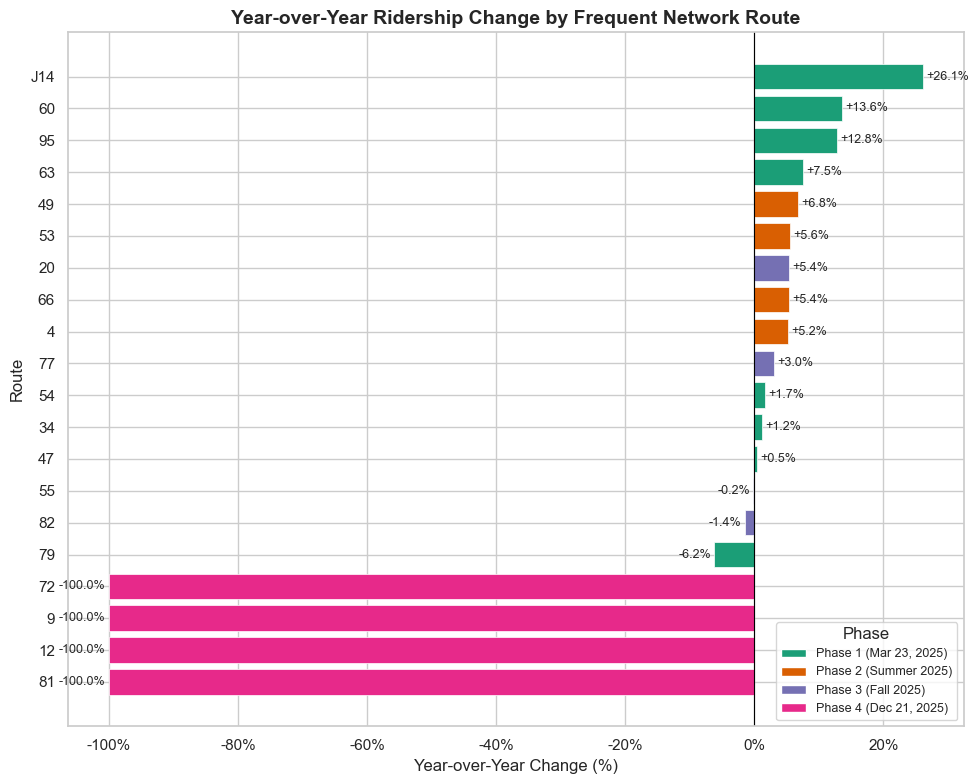

In [5]:
# Horizontal bar chart of YoY ridership changes, colored by phase
df_plot = df_yoy.sort_values("pct_change", ascending=True)  # ascending for horizontal bars

fig, ax = plt.subplots(figsize=(10, 8))

colors = [PHASE_COLORS[p] for p in df_plot["phase"]]
bars = ax.barh(df_plot["route"], df_plot["pct_change"] * 100, color=colors, edgecolor="white", linewidth=0.5)

# Add a vertical line at 0%
ax.axvline(x=0, color="black", linewidth=0.8, linestyle="-")

# Labels and formatting
ax.set_xlabel("Year-over-Year Change (%)", fontsize=12)
ax.set_ylabel("Route", fontsize=12)
ax.set_title("Year-over-Year Ridership Change by Frequent Network Route", fontsize=14, fontweight="bold")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f%%"))

# Add value labels on bars
for bar, val in zip(bars, df_plot["pct_change"]):
    x_pos = bar.get_width()
    ha = "left" if x_pos >= 0 else "right"
    offset = 0.5 if x_pos >= 0 else -0.5
    ax.text(x_pos + offset, bar.get_y() + bar.get_height() / 2,
            f"{val:+.1%}", va="center", ha=ha, fontsize=9)

# Legend for phases
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=PHASE_COLORS[p.phase], label=p.label)
                   for p in FREQUENT_NETWORK_PHASES]
ax.legend(handles=legend_elements, loc="lower right", fontsize=9, title="Phase")

plt.tight_layout()
plt.show()

## Monthly Ridership Trends

Small multiples showing monthly average weekday ridership for each of the 20 Frequent Network routes. The **dashed red line** marks each route's launch date -- the moment it joined the Frequent Network with 10-minute headways.

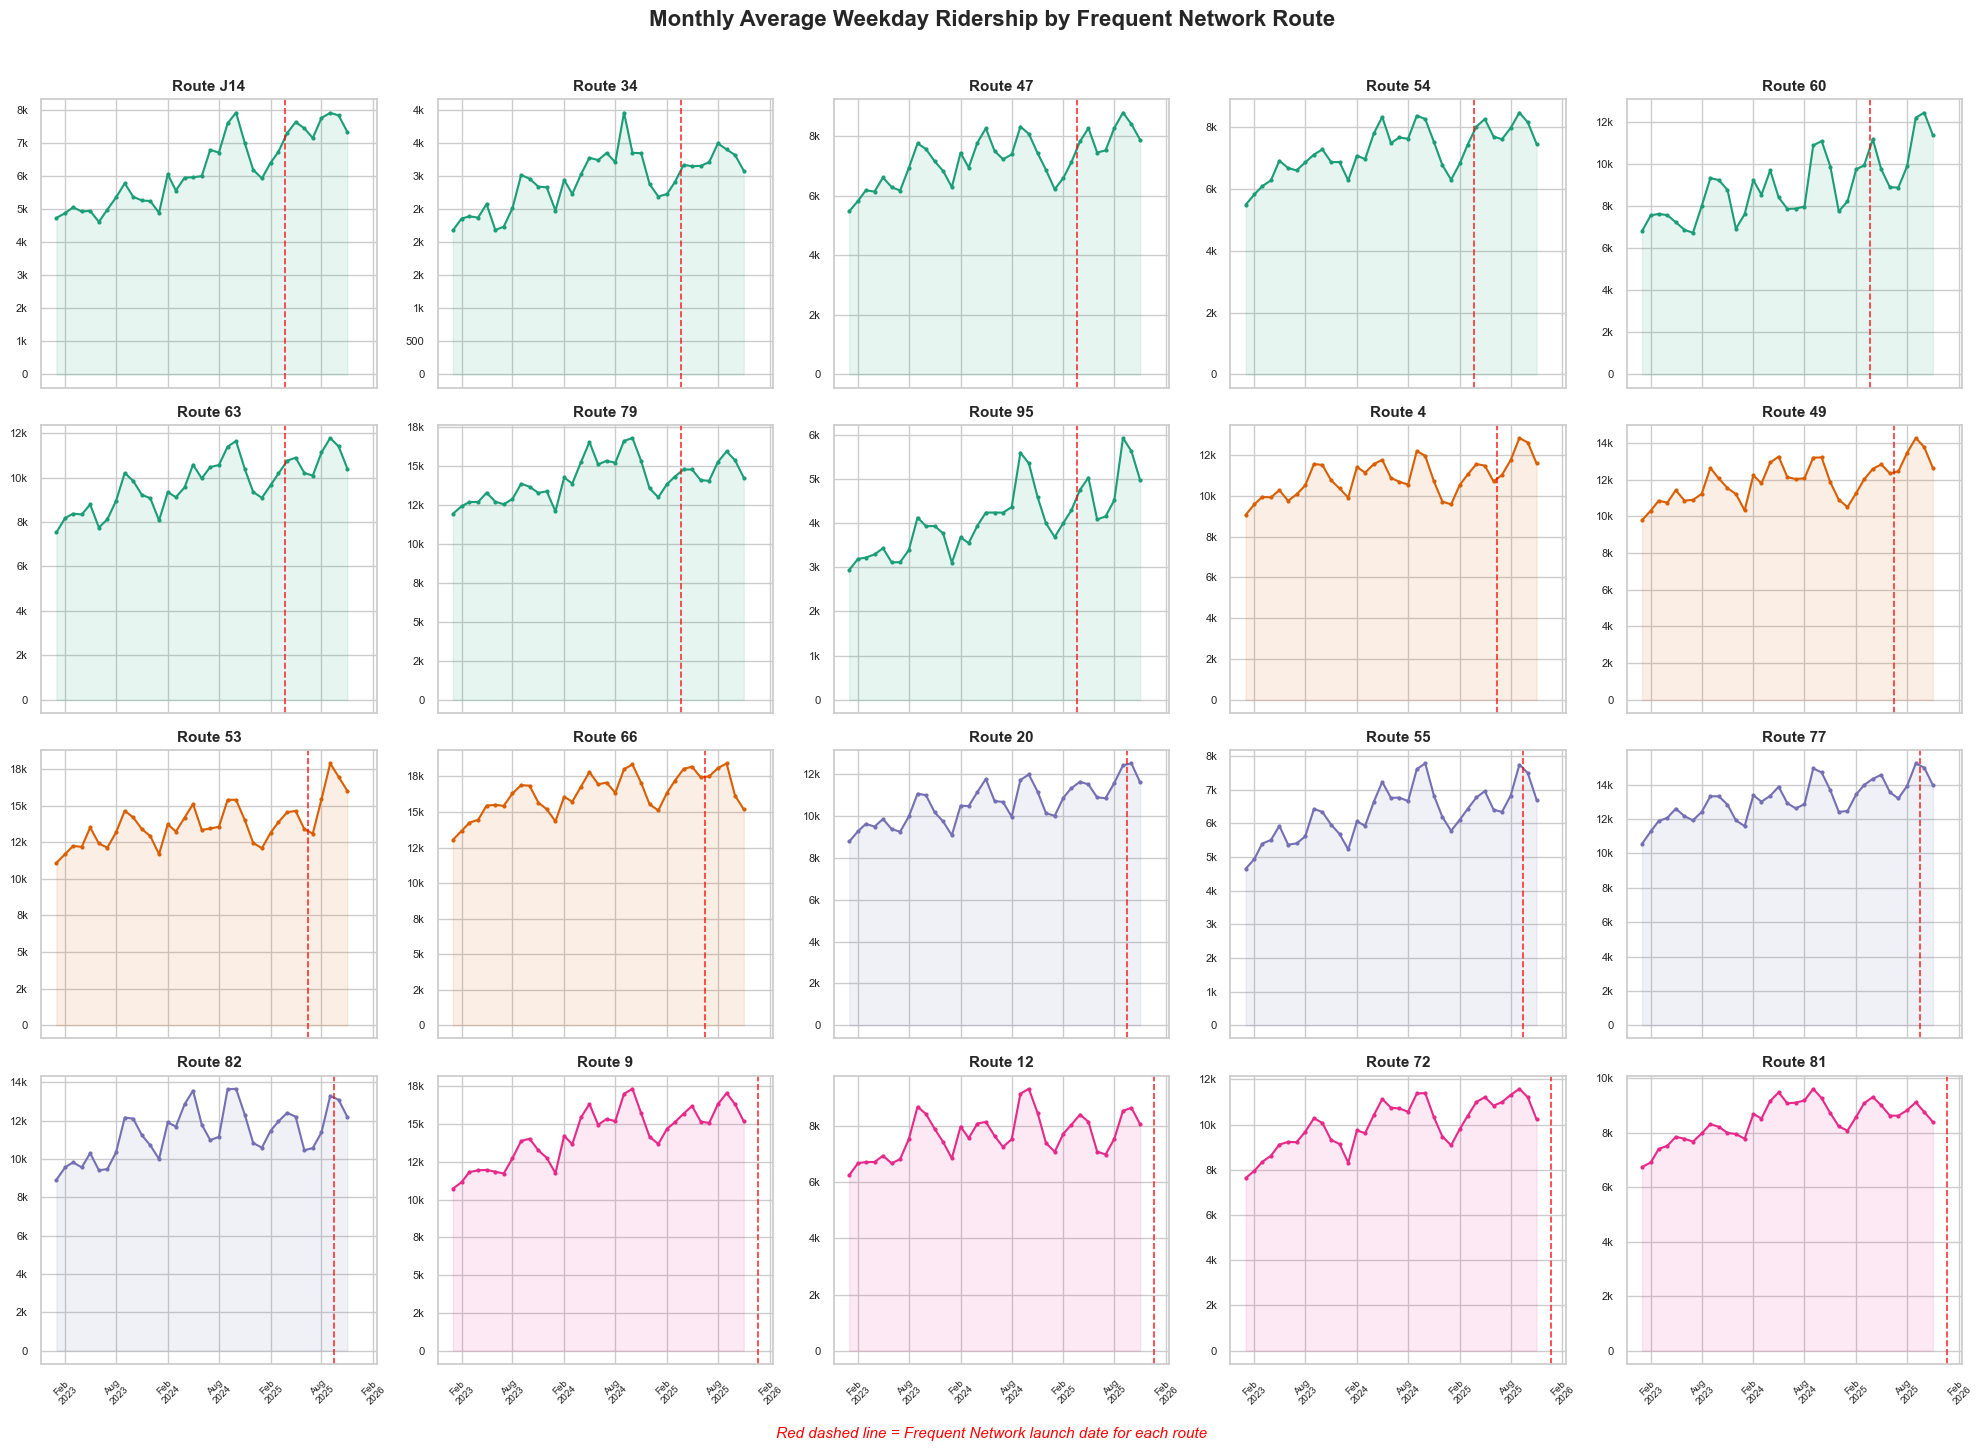

In [6]:
# Small multiples: monthly average weekday ridership for each FN route
# Filter to weekday data for FN routes
df_fn = df_all[
    (df_all["route"].isin(ALL_FREQUENT_ROUTES)) & (df_all["daytype"] == "W")
].copy()

# Create a year-month column for grouping
df_fn["year_month"] = df_fn["date"].dt.to_period("M")

# Monthly averages per route
monthly = (
    df_fn.groupby(["route", "year_month"])["rides"]
    .mean()
    .reset_index()
)
monthly["year_month_dt"] = monthly["year_month"].dt.to_timestamp()

# Plot: 4 rows x 5 columns
fig, axes = plt.subplots(4, 5, figsize=(20, 14), sharex=True)
axes_flat = axes.flatten()

# Sort routes for consistent ordering (by phase, then route number)
sorted_routes = []
for phase in FREQUENT_NETWORK_PHASES:
    sorted_routes.extend(phase.routes)

for idx, route in enumerate(sorted_routes):
    ax = axes_flat[idx]
    route_data = monthly[monthly["route"] == route].sort_values("year_month_dt")
    
    # Determine phase color
    phase = get_phase_for_route(route)
    color = PHASE_COLORS[phase.phase]
    
    ax.plot(route_data["year_month_dt"], route_data["rides"],
            color=color, linewidth=1.5, marker="o", markersize=2)
    ax.fill_between(route_data["year_month_dt"], route_data["rides"],
                    alpha=0.1, color=color)
    
    # Add launch date line
    launch = get_launch_date(route)
    ax.axvline(x=pd.Timestamp(launch), color="red", linestyle="--", linewidth=1.2, alpha=0.8)
    
    ax.set_title(f"Route {route}", fontsize=11, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=7)
    ax.tick_params(axis="y", labelsize=8)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{x/1000:.0f}k" if x >= 1000 else f"{x:.0f}"))
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

fig.suptitle("Monthly Average Weekday Ridership by Frequent Network Route",
             fontsize=16, fontweight="bold", y=1.01)
fig.text(0.5, -0.01, "Red dashed line = Frequent Network launch date for each route",
         ha="center", fontsize=11, color="red", style="italic")

plt.tight_layout()
plt.show()

## Treated vs. Control Group Comparison

To isolate the effect of the Frequent Network designation, we compare the 20 treated routes against a matched **control group** of non-FN routes. Control routes are selected by matching on average pre-treatment weekday ridership -- routes with similar baseline ridership levels that did *not* receive enhanced service.

We index both groups to 100 at March 2025 (Phase 1 launch) to show relative trends on a common scale.

In [7]:
# Select control routes matched on pre-treatment average weekday ridership
control_routes = select_control_routes(df_all, treated_routes=ALL_FREQUENT_ROUTES, n_controls=15)

print(f"Selected {len(control_routes)} control routes:")
print(", ".join(control_routes))

# Show how control routes compare to treated routes in average ridership
weekday_all = df_all[df_all["daytype"] == "W"]
route_avgs = weekday_all.groupby("route")["rides"].mean()

treated_avg = route_avgs[route_avgs.index.isin(ALL_FREQUENT_ROUTES)].mean()
control_avg = route_avgs[route_avgs.index.isin(control_routes)].mean()

print(f"\nAverage weekday ridership (all dates):")
print(f"  Treated (FN) routes:  {treated_avg:,.0f} rides/day")
print(f"  Control routes:       {control_avg:,.0f} rides/day")

Selected 15 control routes:
146, 36, 151, 74, 147, 94, 76, 22, 50, 80, 85, 3, 29, 62, 152

Average weekday ridership (all dates):
  Treated (FN) routes:  9,761 rides/day
  Control routes:       8,731 rides/day


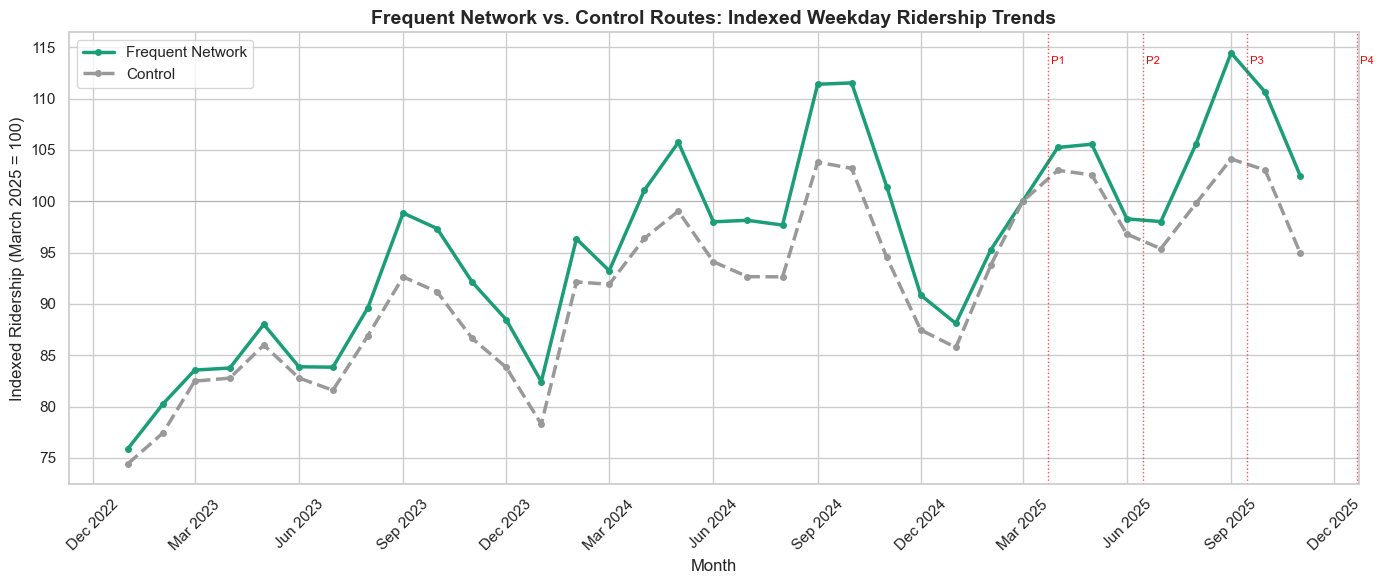

In [8]:
# Aggregate indexed trend: Treated (FN) vs Control routes
# Compute monthly avg weekday ridership for each group
df_weekday = df_all[df_all["daytype"] == "W"].copy()
df_weekday["year_month"] = df_weekday["date"].dt.to_period("M")

# Tag routes as treated or control
df_weekday["group"] = "Other"
df_weekday.loc[df_weekday["route"].isin(ALL_FREQUENT_ROUTES), "group"] = "Frequent Network"
df_weekday.loc[df_weekday["route"].isin(control_routes), "group"] = "Control"

# Filter to just treated and control
df_tc = df_weekday[df_weekday["group"].isin(["Frequent Network", "Control"])]

# Monthly average per group
monthly_group = (
    df_tc.groupby(["group", "year_month"])["rides"]
    .mean()
    .reset_index()
)
monthly_group["year_month_dt"] = monthly_group["year_month"].dt.to_timestamp()

# Index to 100 at March 2025 (Phase 1 launch)
base_period = pd.Period("2025-03", freq="M")
base_values = monthly_group[monthly_group["year_month"] == base_period].set_index("group")["rides"]

monthly_group["indexed"] = monthly_group.apply(
    lambda row: (row["rides"] / base_values[row["group"]]) * 100
    if row["group"] in base_values.index else None,
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for group, color, ls in [("Frequent Network", "#1b9e77", "-"), ("Control", "#999999", "--")]:
    data = monthly_group[monthly_group["group"] == group].sort_values("year_month_dt")
    ax.plot(data["year_month_dt"], data["indexed"],
            label=group, color=color, linewidth=2.5, linestyle=ls, marker="o", markersize=4)

# Add vertical lines for each phase launch
for phase in FREQUENT_NETWORK_PHASES:
    ax.axvline(x=pd.Timestamp(phase.launch_date), color="red", linestyle=":",
               linewidth=1, alpha=0.7)
    ax.text(pd.Timestamp(phase.launch_date), ax.get_ylim()[1] * 0.98,
            f" P{phase.phase}", fontsize=8, color="red", va="top", ha="left")

# Reference line at 100
ax.axhline(y=100, color="gray", linewidth=0.5, linestyle="-", alpha=0.5)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Indexed Ridership (March 2025 = 100)", fontsize=12)
ax.set_title("Frequent Network vs. Control Routes: Indexed Weekday Ridership Trends",
             fontsize=14, fontweight="bold")
ax.legend(fontsize=11, loc="upper left")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Difference-in-Differences Analysis

The **difference-in-differences (DiD)** estimator isolates the causal effect of the Frequent Network program by comparing the change in ridership for treated routes (before vs. after launch) against the same change for control routes. This differences out common trends (e.g., seasonal patterns, system-wide ridership growth) that affect both groups equally.

**DiD = (Treated_post - Treated_pre) - (Control_post - Control_pre)**

A positive DiD estimate suggests the Frequent Network increased ridership beyond what would have happened anyway.

In [9]:
# Build phase_dates mapping: route -> launch date
phase_dates = {}
for route in ALL_FREQUENT_ROUTES:
    phase_dates[route] = get_launch_date(route)

# Prepare DiD panel data
df_did = prepare_did_data(
    df_all,
    treated_routes=ALL_FREQUENT_ROUTES,
    control_routes=control_routes,
    phase_dates=phase_dates,
)

print(f"DiD panel shape: {df_did.shape}")
print(f"Columns: {list(df_did.columns)}")
print()

# Summary statistics by group
summary = (
    df_did[df_did["daytype"] == "W"]
    .groupby(["treated", "post"])["rides"]
    .agg(["mean", "median", "std", "count"])
    .round(1)
)
summary.index = summary.index.set_names(["Treated", "Post"])
summary.columns = ["Mean Rides", "Median Rides", "Std Dev", "Observations"]
print("Mean weekday ridership by group (Treated x Post):")
summary

DiD panel shape: (37275, 7)
Columns: ['route', 'date', 'daytype', 'rides', 'treated', 'post', 'treated_post']

Mean weekday ridership by group (Treated x Post):


Mean Rides  Median Rides  Std Dev  Observations
Treated Post                                                  
False   False      8496.5        8200.0   2016.4          8505
        True       9486.4        9051.5   2117.4          2640
True    False      9700.8        9592.0   3695.6         12768
        True      10125.4        9751.0   4131.4          2092

In [10]:
# Simple DiD estimate (manual 2x2 calculation)
# Filter to weekday observations only
did_weekday = df_did[df_did["daytype"] == "W"]

# Group means
group_means = did_weekday.groupby(["treated", "post"])["rides"].mean()

treated_pre  = group_means.get((True, False), 0)
treated_post = group_means.get((True, True), 0)
control_pre  = group_means.get((False, False), 0)
control_post = group_means.get((False, True), 0)

# DiD estimate
did_estimate = (treated_post - treated_pre) - (control_post - control_pre)
did_pct = did_estimate / treated_pre * 100 if treated_pre != 0 else 0

print("=" * 60)
print("DIFFERENCE-IN-DIFFERENCES ESTIMATE")
print("=" * 60)
print()
print(f"  Treated (FN) routes:")
print(f"    Pre-launch avg:   {treated_pre:>10,.1f} rides/day")
print(f"    Post-launch avg:  {treated_post:>10,.1f} rides/day")
print(f"    Change:           {treated_post - treated_pre:>+10,.1f} rides/day")
print()
print(f"  Control routes:")
print(f"    Pre-launch avg:   {control_pre:>10,.1f} rides/day")
print(f"    Post-launch avg:  {control_post:>10,.1f} rides/day")
print(f"    Change:           {control_post - control_pre:>+10,.1f} rides/day")
print()
print("-" * 60)
print(f"  DiD Estimate:       {did_estimate:>+10,.1f} rides/day")
print(f"  DiD as % of pre:   {did_pct:>+10.1f}%")
print("-" * 60)
print()

if did_estimate > 0:
    print(f"Interpretation: Frequent Network routes gained an estimated")
    print(f"{did_estimate:,.0f} additional weekday rides per day beyond the")
    print(f"background trend observed in control routes ({did_pct:+.1f}%).")
elif did_estimate < 0:
    print(f"Interpretation: Frequent Network routes showed {abs(did_estimate):,.0f}")
    print(f"fewer rides/day than expected given the control group trend ({did_pct:+.1f}%).")
else:
    print("Interpretation: No detectable difference between treated and control groups.")

DIFFERENCE-IN-DIFFERENCES ESTIMATE

  Treated (FN) routes:
    Pre-launch avg:      9,700.8 rides/day
    Post-launch avg:    10,125.4 rides/day
    Change:               +424.6 rides/day

  Control routes:
    Pre-launch avg:      8,496.5 rides/day
    Post-launch avg:     9,486.4 rides/day
    Change:               +989.9 rides/day

------------------------------------------------------------
  DiD Estimate:           -565.3 rides/day
  DiD as % of pre:         -5.8%
------------------------------------------------------------

Interpretation: Frequent Network routes showed 565
fewer rides/day than expected given the control group trend (-5.8%).


## Key Findings

**Year-over-Year Changes:**
- The YoY bar chart above shows how each Frequent Network route's post-launch weekday ridership compares to the same period one year earlier. Routes with positive changes suggest the enhanced service attracted more riders.

**Treated vs. Control Trends:**
- The indexed trend chart reveals whether Frequent Network routes diverged from control routes after launch. If the green (FN) line rises relative to the gray (Control) line after Phase 1, this supports a causal ridership effect.

**Difference-in-Differences:**
- The DiD estimate provides a single number summarizing the program's causal impact, net of background trends.

**Caveats and Limitations:**
1. **Phase 4 has very limited post-data** -- it launched December 21, 2025, so only a few weeks of post-treatment observations may be available. YoY comparisons for Phase 4 routes should be interpreted cautiously.
2. **Seasonality** -- while YoY comparisons and DiD both help control for seasonal patterns, unusual weather events or holidays could still bias results.
3. **Staggered treatment** -- the four phases launched at different times, which complicates the simple DiD estimate. A more rigorous analysis would use a staggered DiD estimator (e.g., Callaway-Sant'Anna).
4. **Spillover effects** -- improved service on FN routes could draw riders from nearby non-FN routes, biasing control group ridership downward and inflating the estimated effect.
5. **Data recency** -- the SODA API data may lag by several days to weeks, so the most recent observations should be checked for completeness.

**Next steps:**
- Run regression-based DiD with route and time fixed effects for statistical inference
- Analyze headway compliance (do FN routes actually achieve 10-minute headways?) in `02_headway_analysis.ipynb`
- Investigate heterogeneous effects by route characteristics (baseline ridership, neighborhood demographics)